In [1]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from tqdm import tqdm
from torch.nn import functional as F
from collections import OrderedDict
import math

# Load Model and Data

In [2]:
Data_01Nami=np.load("data/imread_02Namix40.npy",allow_pickle=True)
Data_00=np.load("data/imread_01x40.npy",allow_pickle=True)
print("Data_01.shape:", Data_00.shape)
print("Data_02Nami.shape:", Data_01Nami.shape)

Data_01.shape: (11990,)
Data_02Nami.shape: (1738,)


In [3]:
def pad(img,Max_shape_0,Max_shape_1):
    imgSize = img.shape
    top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
    left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
    if (imgSize[0] % 2) != 0:
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
    if (imgSize[1] % 2) != 0:     
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
    imgpad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
    return top_size,bottom_size,left_size,right_size,imgpad,imgSize

# GradCAM
* this code is used by: https://github.com/jacobgil/pytorch-grad-cam
* Example: https://colab.research.google.com/drive/1UKcvOL_5sdDPJKU69MiADp8Y1-e24vz9?usp=sharing#scrollTo=AlrrU_yW9ZCX

In [175]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image
from torchvision.models import resnet50

def predict(model,input_tensor,true_y):
    model.eval()
    output = model(input_tensor)
    pre_y = output.argmax(1).cpu().item()
    return pre_y==true_y, pre_y

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=False)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
    gb = np.maximum(gb,0)*(1/np.amax(gb))
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    
    return visualization,cam_gb

# Discussion

In [176]:
# load model
device = "cuda"
model = torch.load("SelfResnet18_300.pkl")
# model = models.resnet50(pretrained=True)
# model.cuda()

target_layers = [model.layer2[-1]]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"

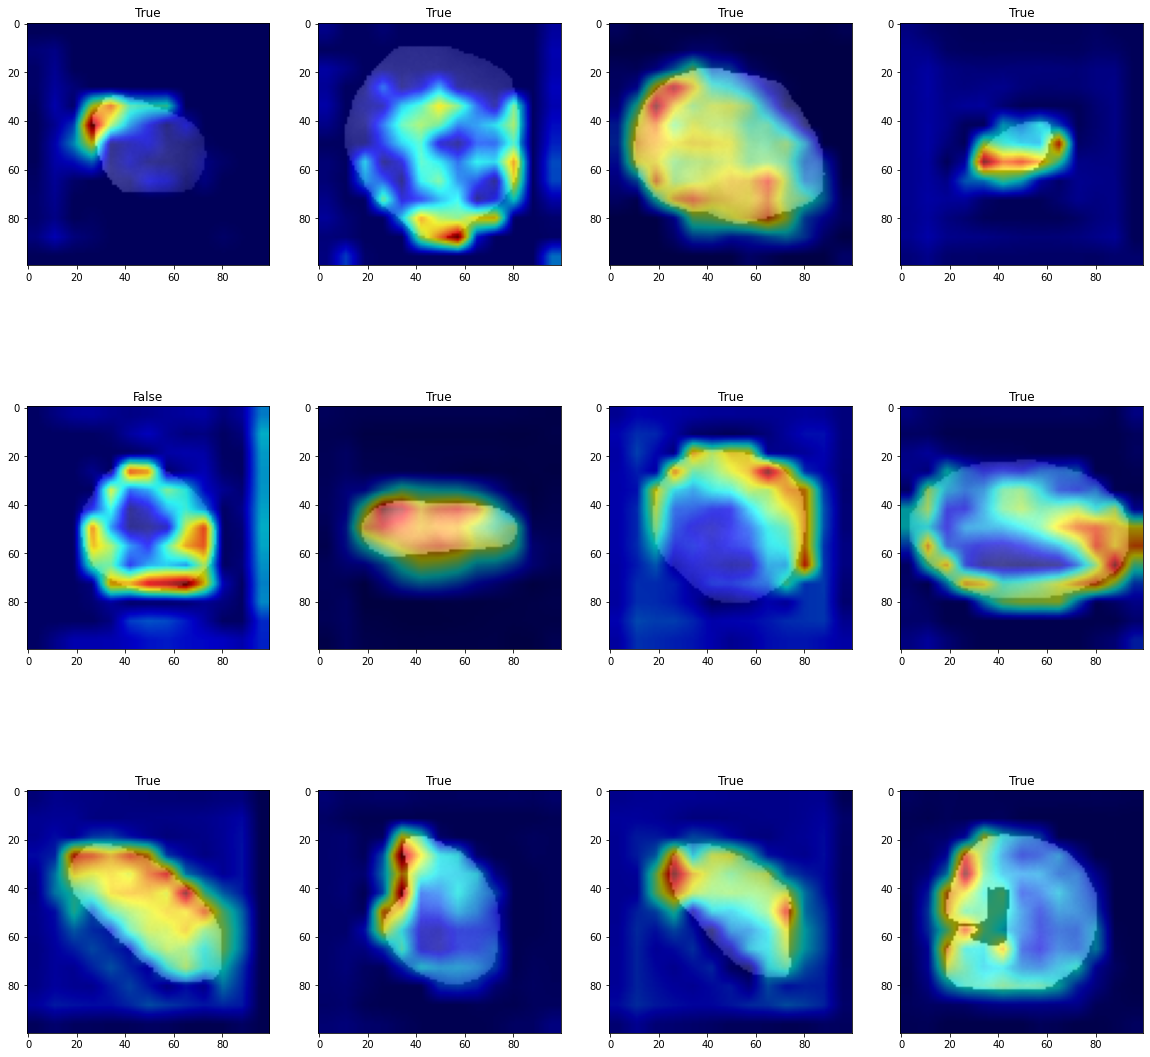

In [177]:
true_y = 0
fig, ax = plt.subplots(3,4, figsize = (20,20))
for n in range(12):
    img=Data_00[n]
    t,b,r,l,imgpad,imgSize = pad(img,100,100)
    imgpad = np.float32(imgpad)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(imgpad).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    visualization,cam_gb = gradcams(model,input_tensor,target_layers,imgpad,optioncam)

    plt.subplot(3,4,n+1)
    plt.title(tf)
    plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))

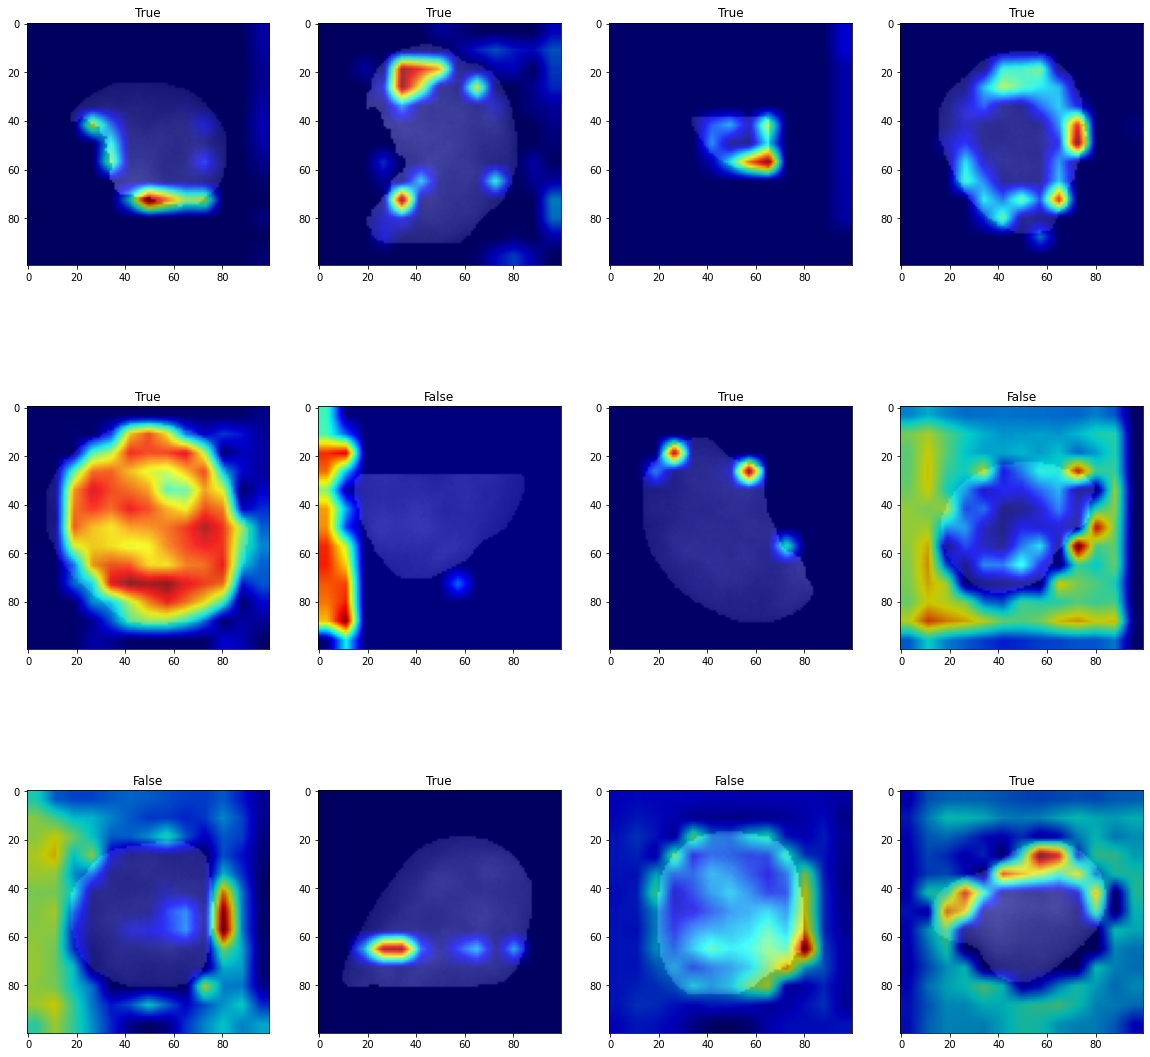

In [178]:
true_y = 1
fig, ax = plt.subplots(3,4, figsize = (20,20))
for n in range(12):
        img=Data_01Nami[n*111]
        t,b,r,l,imgpad,imgSize = pad(img,100,100)
        imgpad = np.float32(imgpad)/255

        transform = transforms.Compose([transforms.ToTensor()])
        input_tensor = transform(imgpad).unsqueeze(0).to(device)

        tf,pred = predict(model,input_tensor,true_y)
        visualization,cam_gb = gradcams(model,input_tensor,target_layers,imgpad,optioncam)
        
        plt.subplot(3,4,n+1)
        plt.title(tf)
        plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))

# Guided-GradCAM

In [182]:
# load model
model = torch.load("SelfResnet18_300.pkl")
# model = models.resnet50(pretrained=True)
# model.cuda()

target_layers = [model.layer4[-1]]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"

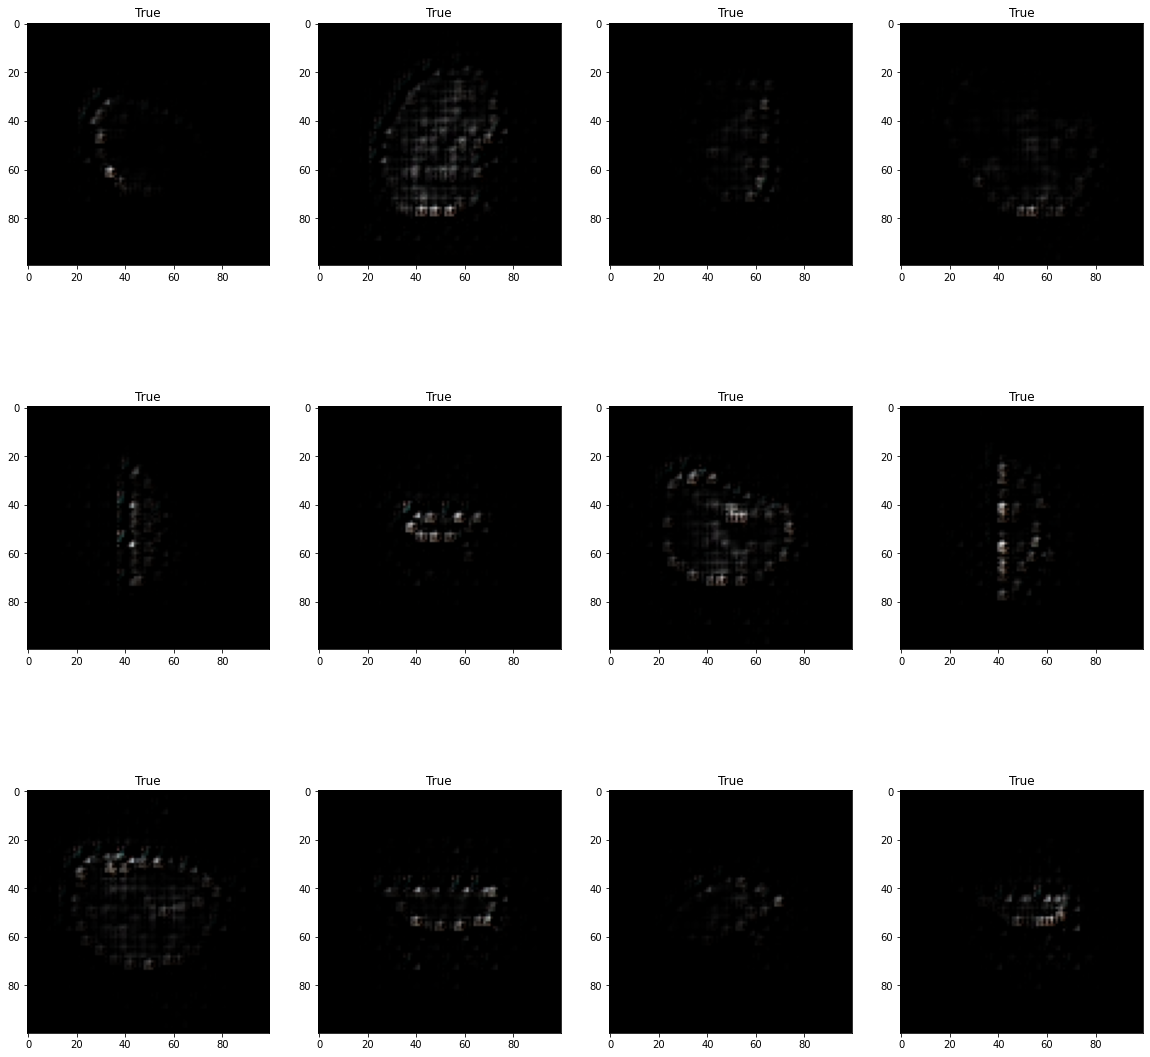

In [183]:
true_y = 0
fig, ax = plt.subplots(3,4, figsize = (20,20))
for n in range(12):
    img=Data_00[n*111]
    t,b,r,l,imgpad,imgSize = pad(img,100,100)
    imgpad = np.float32(imgpad)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(imgpad).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    visualization,cam_gb = gradcams(model,input_tensor,target_layers,imgpad,optioncam)

    plt.subplot(3,4,n+1)
    plt.title(tf)
    plt.imshow(cv2.cvtColor(cam_gb, cv2.COLOR_BGR2RGB))

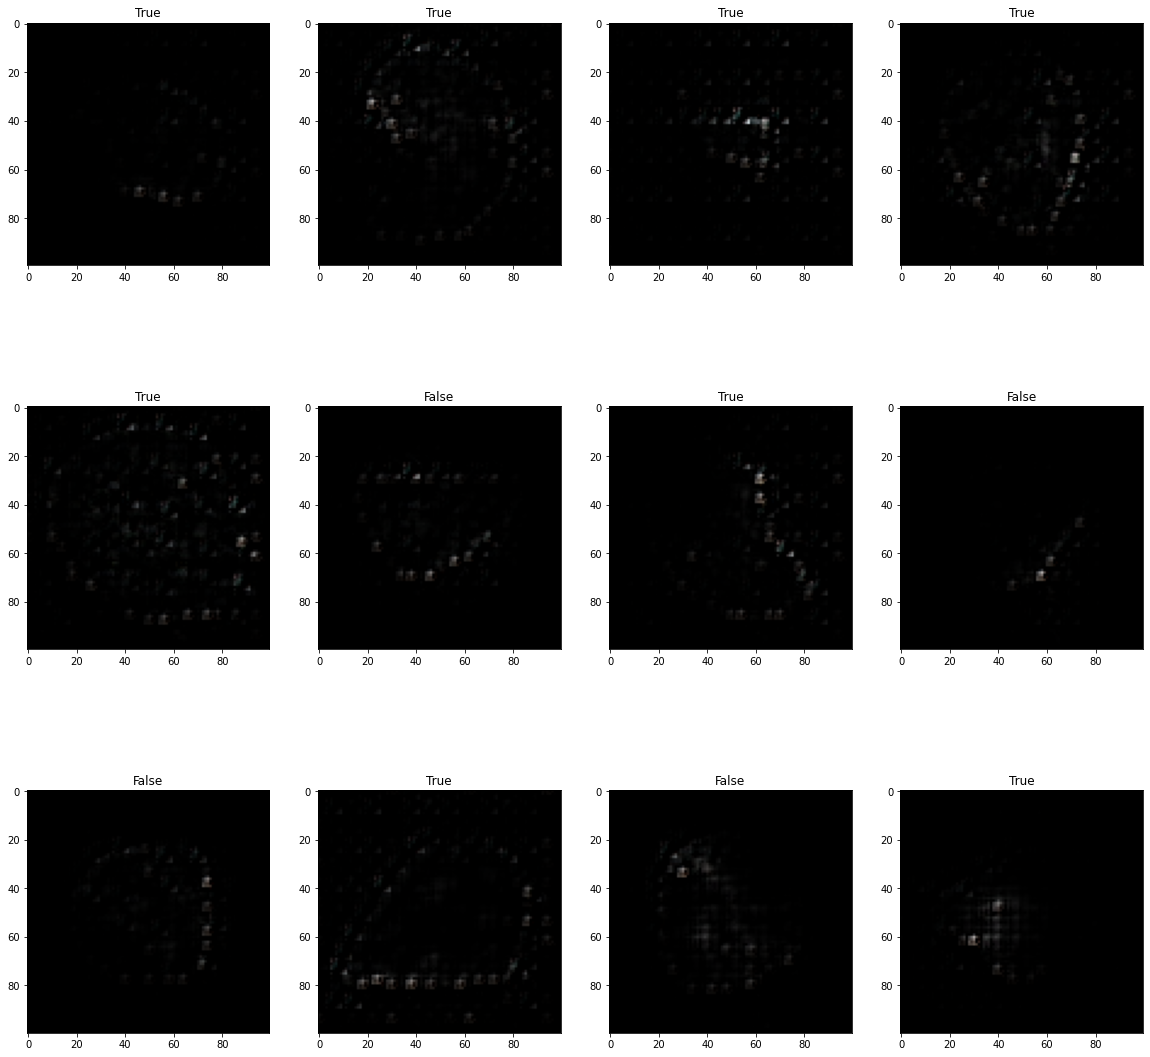

In [184]:
true_y = 1
fig, ax = plt.subplots(3,4, figsize = (20,20))
for n in range(12):
        img=Data_01Nami[n*111]
        t,b,r,l,imgpad,imgSize = pad(img,100,100)
        imgpad = np.float32(imgpad)/255

        transform = transforms.Compose([transforms.ToTensor()])
        input_tensor = transform(imgpad).unsqueeze(0).to(device)

        tf,pred = predict(model,input_tensor,true_y)
        visualization,cam_gb = gradcams(model,input_tensor,target_layers,imgpad,optioncam)
        
        plt.subplot(3,4,n+1)
        plt.title(tf)
        plt.imshow(cv2.cvtColor(cam_gb, cv2.COLOR_BGR2RGB))

# debug

In [169]:
def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
        
    targets = None
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=True)
    
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb

    
    print(type(grayscale_cam[1,1]),np.amax(grayscale_cam),np.amin(grayscale_cam))
    print(type(visualization[1,1,1]),np.amax(visualization),np.amin(visualization))
    print(type(gb[1,1,1]),np.amax(gb),np.amin(gb))
    print(type(cam_gb[1,1,1]),np.amax(cam_gb),np.amin(cam_gb))
    
    # relu
    gb = gb
    gb = np.maximum(gb,0)*(1/np.amax(gb))
#     # sigmoid
#     gb = 1/(1 + np.exp(-gb))
#     # try 
#     if np.min(gb)<0:
#         gb = gb - np.min(gb)
#     if np.amax(gb)>1:
#         gb = gb / np.amax(gb)
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    print(type(gb[1,1,1]),np.amax(gb),np.amin(gb))
    print(type(cam_gb[1,1,1]),np.amax(cam_gb),np.amin(cam_gb))

    plt.figure(figsize=(16,12))
    plt.subplot(1,4,1)
    plt.title("grayscale_cam")
    plt.imshow(grayscale_cam)
    plt.subplot(1,4,2)
    plt.title("visualization")
    plt.imshow(visualization)
    plt.subplot(1,4,3)
    plt.title("gb")
    plt.imshow(gb)
    plt.subplot(1,4,4)
    plt.title("cam_gb")
    plt.imshow(cam_gb)
    
    return cam_gb

In [170]:
# load model
model = torch.load("SelfResnet18_300.pkl")
# model = models.resnet18(pretrained=True)
# model.cuda()
target_layers = [model.layer4]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"

<class 'numpy.float32'> 0.9999999 0.0
<class 'numpy.uint8'> 255 0
<class 'numpy.float32'> 0.5940247 -0.64405763
<class 'numpy.float32'> 0.51265085 -0.47661343
<class 'numpy.float32'> 1.0 0.0
<class 'numpy.float32'> 0.8630126 0.0


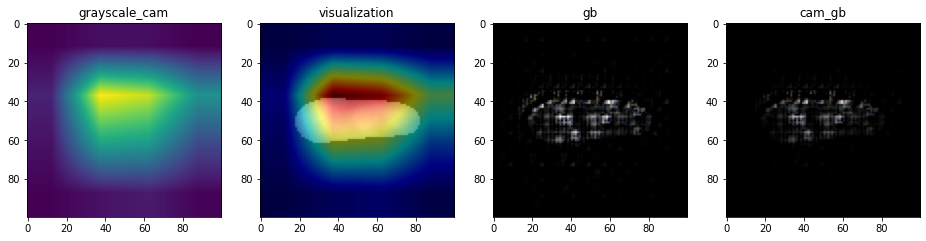

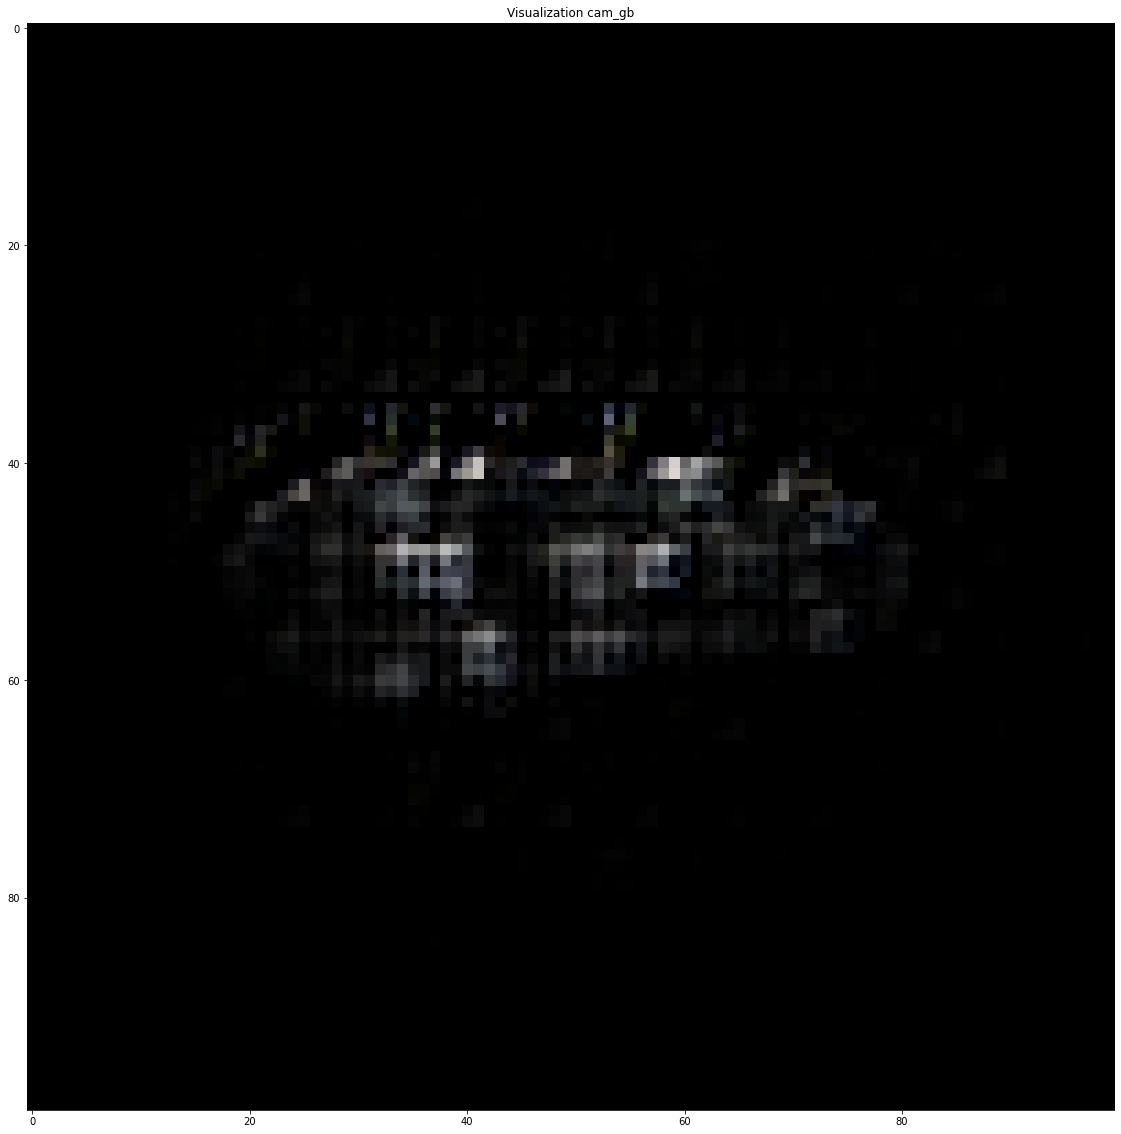

In [172]:
true_y = 0
img=Data_00[5]
t,b,r,l,imgpad,imgSize = pad(img,100,100)
imgpad = np.float32(imgpad)/255
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(imgpad).unsqueeze(0).to(device)
tf,pred = predict(model,input_tensor,true_y)
visualization = gradcams(model,input_tensor,target_layers,imgpad,optioncam)
plt.figure(figsize=(20,20))
plt.title("Visualization cam_gb")
plt.imshow(visualization)

249


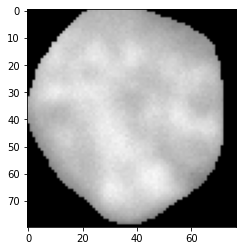

In [97]:
img=Data_00[1]*3
print(np.amax(img))
# plt.figure(figsize=(20,20))
plt.imshow(img)

In [124]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_s